In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
import nltk
from wordcloud import WordCloud
import string
from functools import reduce
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package stopwords to /Users/kyryl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kyryl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kyryl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/kyryl/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [2]:
lemmatizer = WordNetLemmatizer()


def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


def get_stopwords_remover(stop_words):
    return lambda words: words[~words.isin(stop_words)]


def lemmatize(words):
    return words.apply(lemmatizer.lemmatize)


def preprocessing_pipeline(steps):
    return lambda raw_text: reduce(lambda data, func: func(data), steps, raw_text)


def lowercase(words):
    return words.str.lower()

In [3]:
stop_words = set(stopwords.words('english'))
remove_stopwords = get_stopwords_remover(stop_words)

In [4]:
pipe = preprocessing_pipeline([
    remove_punctuation,
    word_tokenize,
    pd.Series,
    lowercase,
    remove_stopwords,
    lemmatize
])

In [5]:
with open('../data/doyle.txt') as file:
    doyle = file.read()
with open('../data/doyle-2.txt') as file:
    doyle += file.read()

with open('../data/poe.txt') as file:
    poe = file.read()
with open('../data/poe-2.txt') as file:
    poe += file.read()

In [6]:
doyle_words = pipe(doyle)
poe_words = pipe(poe)

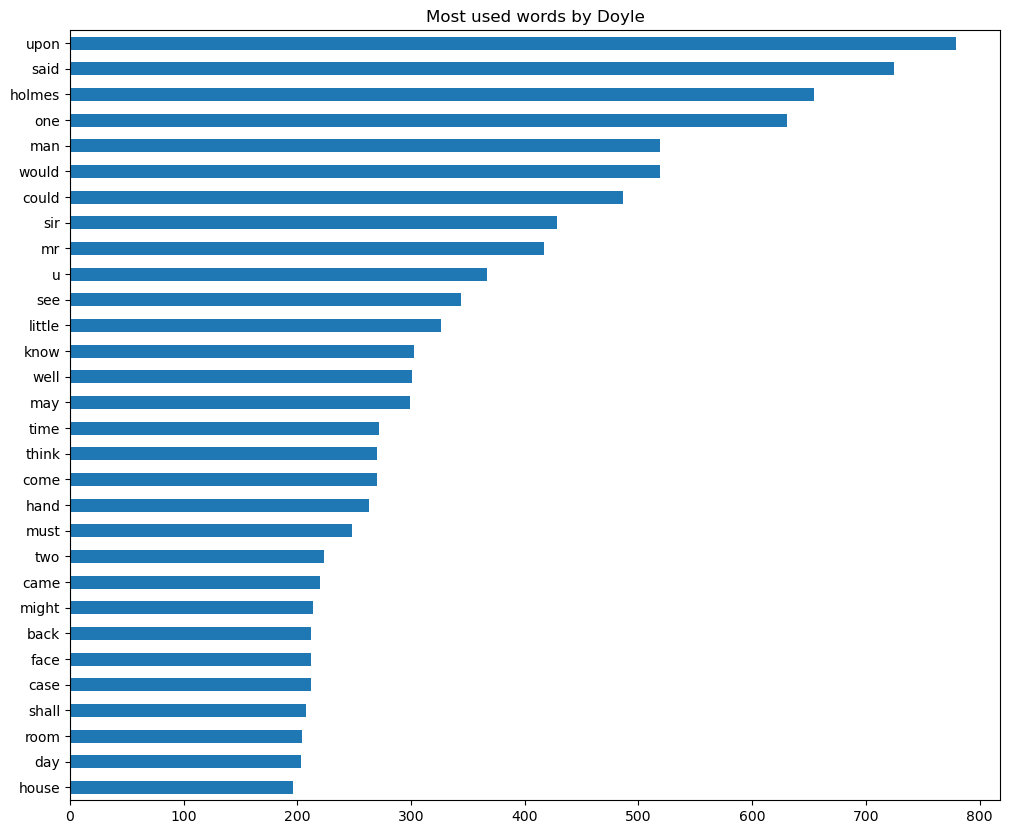

In [7]:
plt.figure(figsize=(12, 10))
plt.title('Most used words by Doyle')
doyle_words.value_counts().head(30).plot.barh()
plt.gca().invert_yaxis();

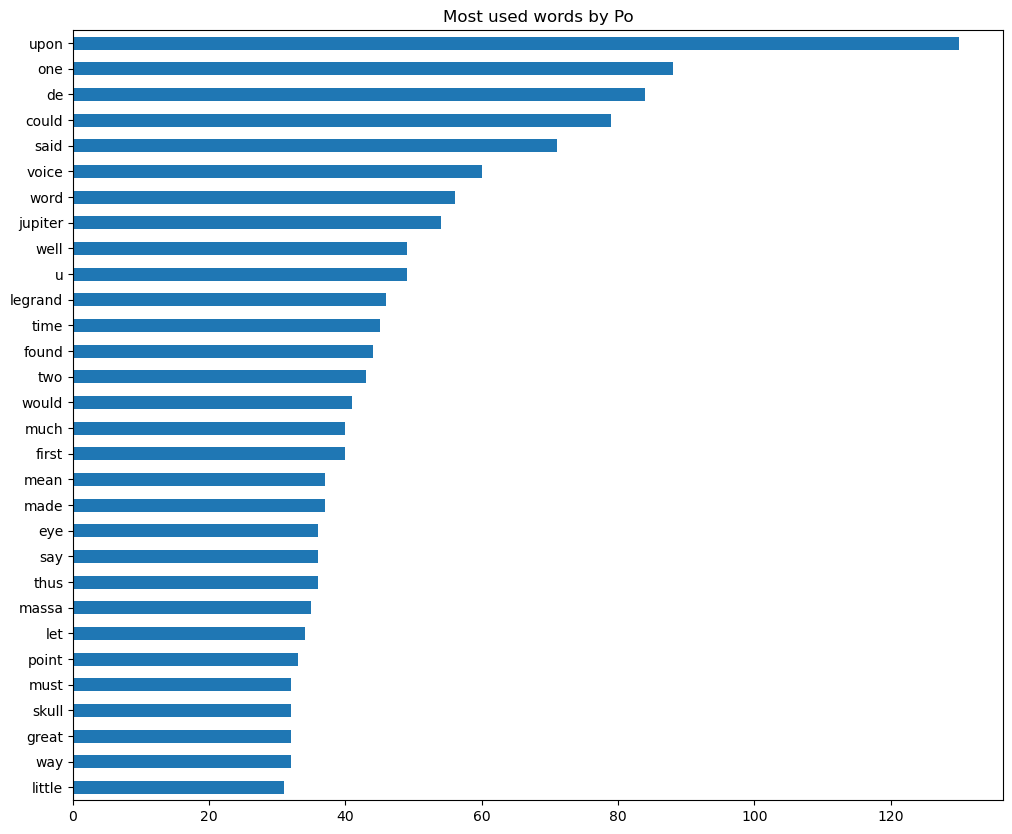

In [8]:
plt.figure(figsize=(12, 10))
plt.title('Most used words by Po')
poe_words.value_counts().head(30).plot.barh()
plt.gca().invert_yaxis();

In [9]:
extra_stopwords = {'upon', 'could', 'would', 'us', 'u', 'man', 'mr', 'de', 'may', 'must', 'thus', 'say', 'much'}
remove_extra_stopwords = get_stopwords_remover(extra_stopwords)

In [10]:
doyle_words = remove_extra_stopwords(doyle_words)
poe_words = remove_extra_stopwords(poe_words)

In [11]:
wordcloud = WordCloud(
    background_color='white',
    width=1000, height=1000
)

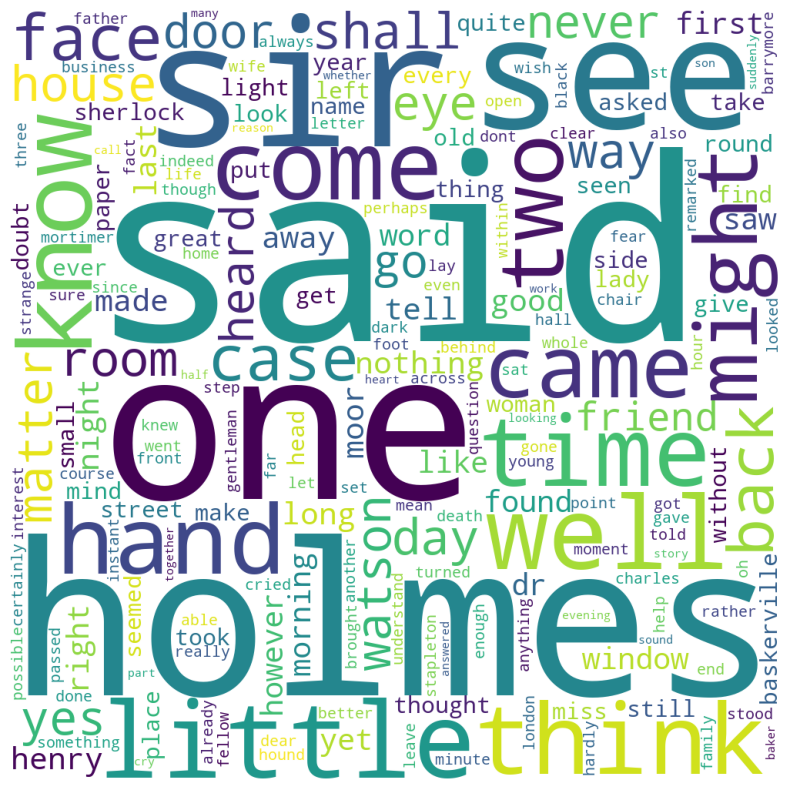

In [12]:
doyle_cloud = wordcloud.generate_from_frequencies(doyle_words.value_counts())

plt.figure(figsize=(12, 10))
plt.imshow(doyle_cloud)
plt.axis(False);

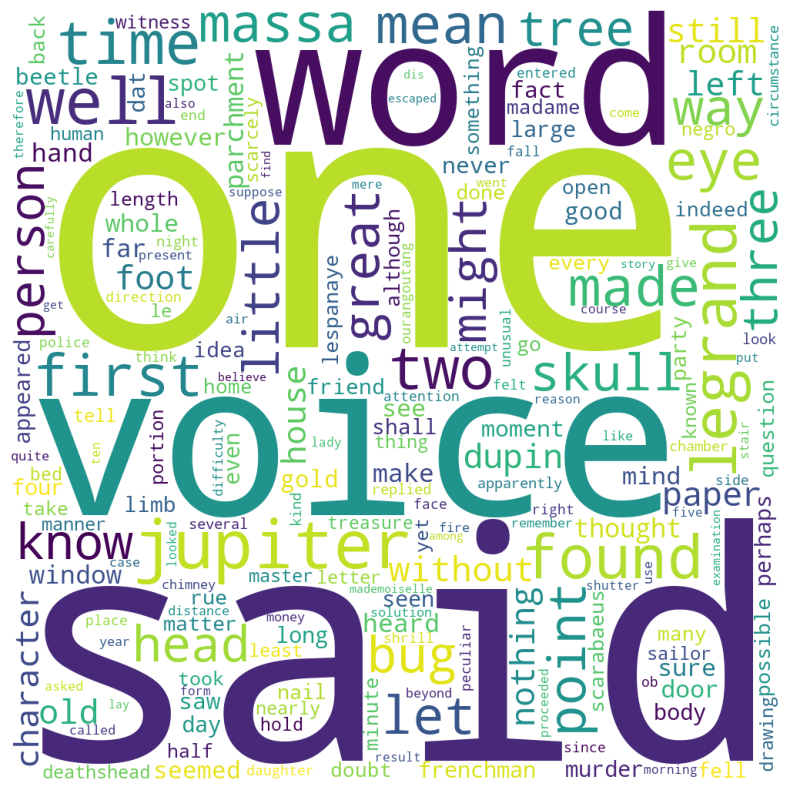

In [13]:
poe_cloud = wordcloud.generate_from_frequencies(poe_words.value_counts())

plt.figure(figsize=(12, 10))
plt.imshow(poe_cloud)
plt.axis(False);

In [14]:
def get_wordnet_pos(w):
    treebank_tag = nltk.pos_tag([w])[0][1]
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [15]:
doyle_score = 0
poe_score = 0
doyle_count = 0
poe_count = 0

for word, count in list(doyle_words.value_counts().items()):
    synsets = list(swn.senti_synsets(word, get_wordnet_pos(word)))
    if synsets:
        score = synsets[0].pos_score() - synsets[0].neg_score()
        doyle_score += score * count
        doyle_count += count

for word, count in list(poe_words.value_counts().items()):
    synsets = list(swn.senti_synsets(word, get_wordnet_pos(word)))
    if synsets:
        score = synsets[0].pos_score() - synsets[0].neg_score()
        poe_score += score * count
        poe_count += count

doyle_score /= len(doyle_words)
poe_score /= len(poe_words)

print(f'Doyle score: {doyle_score}, Poe score: {poe_score}')

Doyle score: 0.0028875187754810096, Poe score: 0.0028881887219259976


In [16]:
author = 'Poe' if poe_score < doyle_score else 'Doyle'
print(f'{author} wrote more gloomy novels')

Doyle wrote more gloomy novels
